In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
(X, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X.shape

(60000, 28, 28)

In [4]:
X = (X - 127.5) / 127.5  #-1 to 1  for tanh activation func

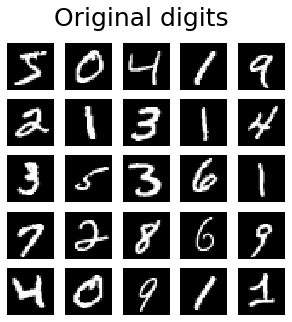

In [5]:
def show_data(X, title=""):
    plt.figure(figsize=(5,5))
    
    i = 1
    for img in X:
        plt.subplot(5, 5, i)
        plt.imshow(img.reshape((28, 28)), cmap='gray')
        plt.axis('off')
        i+=1
        if i>25: break

    plt.suptitle(title, fontsize = 25)
    plt.show()
    
show_data(X, title="Original digits")

In [6]:
gen_opt = Adam(0.0001, 0.5)
disc_opt = Adam(0.0002, 0.5)
noise_dim = 100

In [7]:
Generator = Sequential()

Generator.add(Dense(1024,input_dim=noise_dim))
Generator.add(BatchNormalization(momentum=0.8))
Generator.add(LeakyReLU(0.2))

Generator.add(Dense(7*7*128,input_dim=noise_dim))
Generator.add(BatchNormalization(momentum=0.8))
Generator.add(LeakyReLU(0.2))

Generator.add(Reshape((7,7,128)))

Generator.add(UpSampling2D((2,2)))
Generator.add(Conv2D(64,(2,2),padding='same',
                    kernel_initializer=RandomNormal(0,0.02)))
Generator.add(BatchNormalization(momentum=0.8))
Generator.add(LeakyReLU(0.2))

Generator.add(UpSampling2D((2,2)))
Generator.add(Conv2D(1,(3,3),padding='same',activation = 'tanh',
                    kernel_initializer=RandomNormal(0,0.02)))

In [8]:
Generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_2 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)        

In [9]:
Discriminator = Sequential()

Discriminator.add(Conv2D(64,(5,5),strides=2,padding='same',
                        kernel_initializer=RandomNormal(0,0.02),
                        input_shape=(28,28,1)))
Discriminator.add(LeakyReLU(0.2))

Discriminator.add(Conv2D(64,(5,5),strides=2,padding='same',
                        kernel_initializer=RandomNormal(0,0.02)))
Discriminator.add(LeakyReLU(0.2))

Discriminator.add(Flatten())

Discriminator.add(Dense(256))
Discriminator.add(LeakyReLU(0.2))

Discriminator.add(Dropout(0.5))
Discriminator.add(Dense(1, activation='sigmoid'))
Discriminator.compile(loss='binary_crossentropy', optimizer=disc_opt)


In [10]:
Discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          102464    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               803072    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)              

In [11]:
noise=Input(shape=(noise_dim,))
gen_data=Generator(noise)
Discriminator.trainable=False
dis_data = Discriminator(gen_data)
GAN = Model(noise,dis_data)
GAN.compile(loss='binary_crossentropy',optimizer=gen_opt)
GAN.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         6595073   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 907457    
Total params: 7,502,530
Trainable params: 6,580,353
Non-trainable params: 922,177
_________________________________________________________________


In [12]:
fixed_noise = np.random.normal(0, 1, size=(100, noise_dim))
epochs=21
batch_size=128
steps_per_epoch = len(X)//batch_size
dlosses=[]
glosses=[]

In [13]:
def show_generated_digits(title, epoch):
    imgs = Generator.predict(fixed_noise)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((28,28)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 25)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()

C:\Users\Indranil\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Indranil\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  0
discriminator loss:  0.5865512
generator loss:  0.9491546
--------------------------------------------------------------------------------


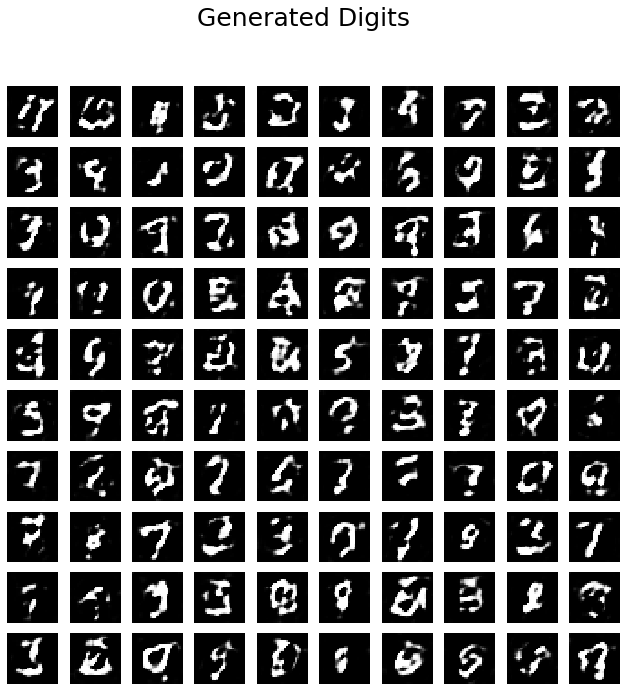

epoch:  1
discriminator loss:  0.58549714
generator loss:  1.1099725
--------------------------------------------------------------------------------
epoch:  2
discriminator loss:  0.6089793
generator loss:  0.694515
--------------------------------------------------------------------------------
epoch:  3
discriminator loss:  0.6002373
generator loss:  1.0066265
--------------------------------------------------------------------------------
epoch:  4
discriminator loss:  0.6001853
generator loss:  0.8411683
--------------------------------------------------------------------------------
epoch:  5
discriminator loss:  0.5729684
generator loss:  0.9255212
--------------------------------------------------------------------------------


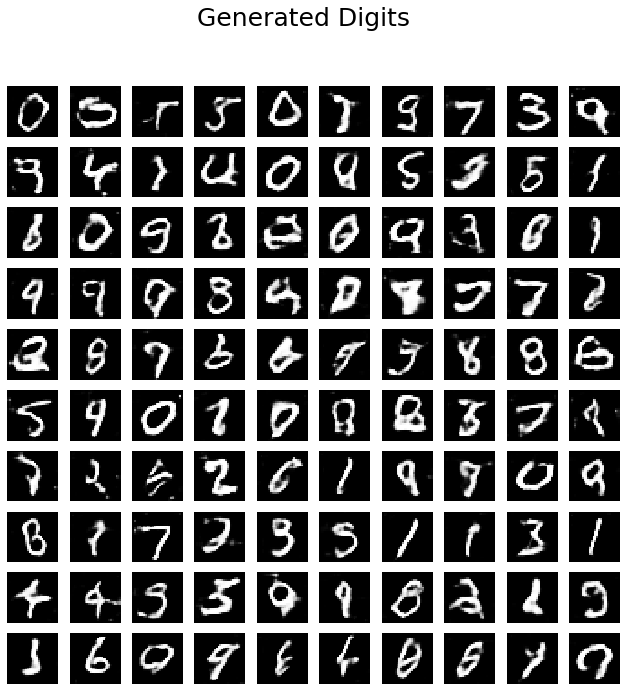

epoch:  6
discriminator loss:  0.59039295
generator loss:  1.075098
--------------------------------------------------------------------------------
epoch:  7
discriminator loss:  0.6139686
generator loss:  1.5629468
--------------------------------------------------------------------------------
epoch:  8
discriminator loss:  0.57840943
generator loss:  1.1939808
--------------------------------------------------------------------------------
epoch:  9
discriminator loss:  0.5598748
generator loss:  1.4454497
--------------------------------------------------------------------------------
epoch:  10
discriminator loss:  0.5789288
generator loss:  0.7947886
--------------------------------------------------------------------------------


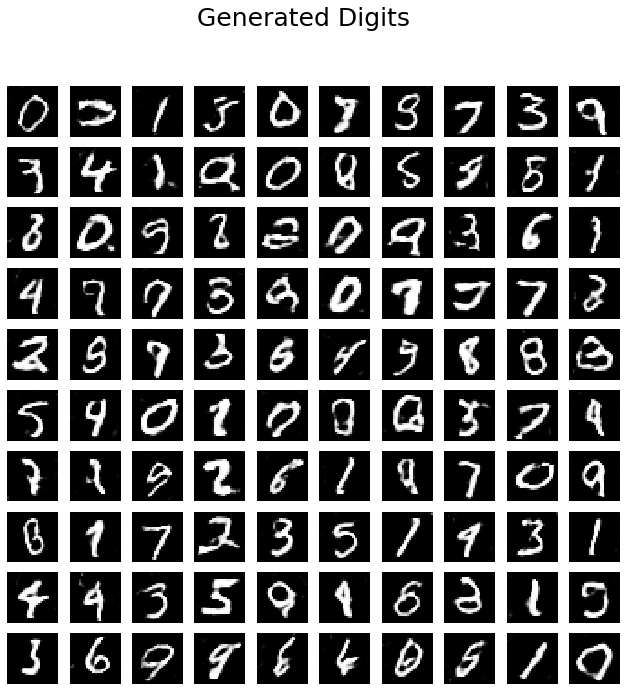

epoch:  11
discriminator loss:  0.57789856
generator loss:  0.9831518
--------------------------------------------------------------------------------
epoch:  12
discriminator loss:  0.55002713
generator loss:  0.9148679
--------------------------------------------------------------------------------
epoch:  13
discriminator loss:  0.5357771
generator loss:  1.1312168
--------------------------------------------------------------------------------
epoch:  14
discriminator loss:  0.54526544
generator loss:  1.497482
--------------------------------------------------------------------------------
epoch:  15
discriminator loss:  0.56245875
generator loss:  1.7954382
--------------------------------------------------------------------------------


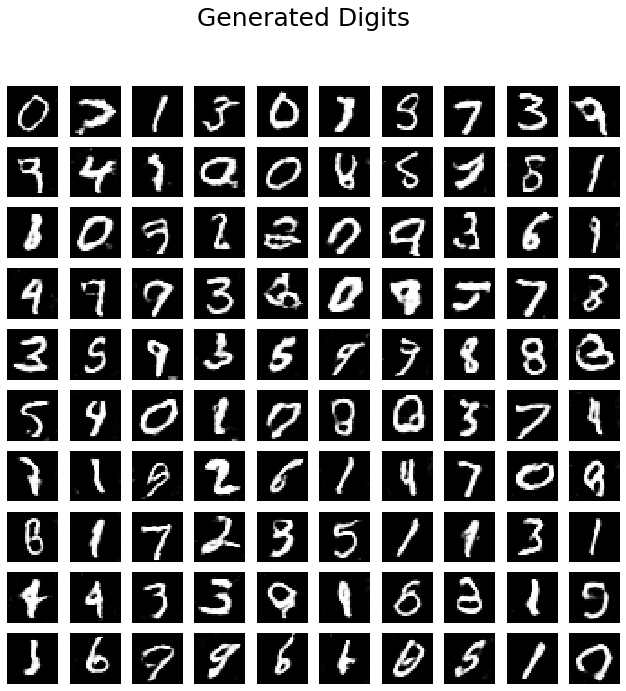

epoch:  16
discriminator loss:  0.5366682
generator loss:  0.96821153
--------------------------------------------------------------------------------
epoch:  17
discriminator loss:  0.5279875
generator loss:  0.83280784
--------------------------------------------------------------------------------
epoch:  18
discriminator loss:  0.52169037
generator loss:  1.2443233
--------------------------------------------------------------------------------
epoch:  19
discriminator loss:  0.52158475
generator loss:  0.9907027
--------------------------------------------------------------------------------
epoch:  20
discriminator loss:  0.61268663
generator loss:  0.6843664
--------------------------------------------------------------------------------


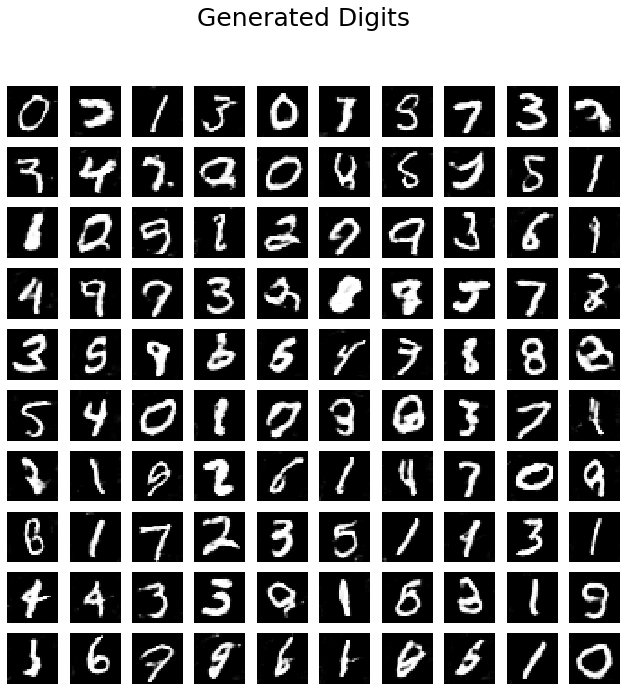

In [14]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_data = Generator.predict(input_gen)
        
        real_data = X[np.random.randint(0, X.shape[0], size=batch_size)]
        real_data = real_data.reshape((batch_size, 28, 28, 1))
        
        input_disc = np.concatenate((real_data, fake_data))

        label_disc = np.zeros(2*batch_size)
        label_disc[:batch_size] = 0.9
        label_disc[batch_size:] = 0.1
        loss_disc = Discriminator.train_on_batch(input_disc, label_disc)

        label_gen = np.ones(batch_size)
        loss_gen = GAN.train_on_batch(input_gen, label_gen)

    dlosses.append(loss_disc)
    glosses.append(loss_gen)
    print("epoch: ", epoch)
    print("discriminator loss: ", loss_disc)
    print("generator loss: ", loss_gen)
    print("-"*80)
    
    if epoch % 5 == 0:
        show_generated_digits("Generated Digits", epoch)

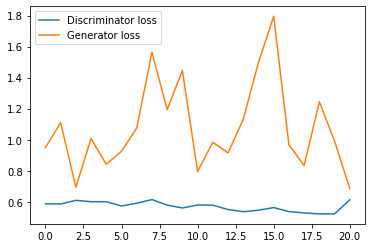

In [15]:
plt.plot(dlosses,label='Discriminator loss')
plt.plot(glosses,label='Generator loss')
plt.legend()
plt.show()